# Task III - Time series analysis

In [ ]:
import numpy as np

In [146]:
import pandas as pd

#Reading the data
X_KV = pd.read_csv('../X_KV.csv')   #JNSM_KV_flashcrowd_1 
Y_KV = pd.read_csv('../Y_KV.csv')   
X_VoD = pd.read_csv('../X_VoD.csv') #JNSM_VoD_flashcrowd_1 
Y_VoD = pd.read_csv('../Y_VoD.csv') 

X_KV_2 = pd.read_csv('../X_KV_2.csv')    #JNSM_KV_flashcrowd_2
Y_KV_2 = pd.read_csv('../Y_KV_2.csv')    
X_VoD_2 = pd.read_csv('../X_VoD_2.csv')  #JNSM_VoD_flashcrowd_2
Y_VoD_2 = pd.read_csv('../Y_VoD_2.csv')     

#Concatenate datasets
X_KV = pd.concat([X_KV, X_KV_2], ignore_index=True)
Y_KV = pd.concat([Y_KV, Y_KV_2], ignore_index=True)
X_VoD = pd.concat([X_VoD, X_VoD_2], ignore_index=True)
Y_VoD = pd.concat([Y_VoD, Y_VoD_2], ignore_index=True)

#Remove the first two columns that index the samples and retrieve all other values by using iloc()
X_KV = X_KV.iloc[:,2:]  
Y_KV = Y_KV.iloc[:, 2:] 
X_VoD = X_VoD.iloc[:,2:]
Y_VoD = Y_VoD.iloc[:, 2:]

#FedCSIS Data
X_CSIS = pd.read_csv('../FedCSIS_X.csv')   
Y_CSIS = pd.read_csv('../FedCSIS_Y.csv')

X_CSIS = X_CSIS.iloc[:,1:] 
Y_CSIS = Y_CSIS.iloc[:,1:]

### Task III.2
Outliers elimination. Before applying any method, we remove outliers if there are any. Use one of the methods from project 1 to eliminate the outliers. It should be the same as in Task I. 

In [148]:
#1. Pre-processing: column-wise standardization (needed for outlier removal)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_KV_columns_scaled = scaler.fit_transform(X_KV)
X_KV_columns_scaled = pd.DataFrame(X_KV_columns_scaled)

X_VoD_columns_scaled = scaler.fit_transform(X_VoD)
X_VoD_columns_scaled = pd.DataFrame(X_VoD_columns_scaled)

X_CSIS_columns_scaled = scaler.fit_transform(X_CSIS)
X_CSIS_columns_scaled = pd.DataFrame(X_CSIS_columns_scaled)

In [149]:
#2. Outlier removal: Threshold that keeps 99% of outliers in the dataset (see Project2 Task I)

#Number of outliers
#Use this function to find the threshold that keeps 99% of the samples in the dataset
def count(features,thr): 
    counter = 0
    features = features.T
    for col in features:
        if any(np.absolute(features[col]) >= thr):
            counter += 1
    return counter

#For dataset JNSM_KV_flashcrowd 99% of samples correspond to at least 18.810 samples, i.e. maximal 190 outliers
#Choose threshold 69

#For dataset JNSM_VoD_flashcrowd_1 99% of samples correspond to at least 34.650 samples, i.e. maximal 350 outliers
#Choose threshold 54

#For dataset FedCSIS 99% of samples correspond to at least 1898 samples, i.e. maximal 19 outliers
#Choose threshold 4

# Function that removes outliers from the target scores
# Note: Input is of the format pd.DataFrame
def outlier_detection(features, labels, thr): 
    features = features.T
    for col in features:
        if any(np.absolute(features[col]) >= thr):
            labels = labels.drop([col],axis=0)
    return labels #Returns reduced feature matrix and target scores

Y_KV = outlier_detection(X_KV_columns_scaled, Y_KV['ReadsAvg'], 69)
Y_VoD = outlier_detection(X_VoD_columns_scaled, Y_VoD['DispFrames'], 54)
Y_CSIS = outlier_detection(X_CSIS_columns_scaled, Y_CSIS['host1619_/'], 4)

#Split FedCSIS data into train and test set for later tasks
from sklearn.model_selection import train_test_split
Y_CSIS_train, Y_CSIS_test = train_test_split(Y_CSIS, test_size=0.3, shuffle = False)
%store Y_CSIS_train Y_CSIS_test

Stored 'Y_CSIS_train' (Series)
Stored 'Y_CSIS_test' (Series)


### Task III.3
Determine which of the two time series that have been assigned to you are stationary. For this, you can use the Augmented Dicky-Fuller (ADF) test [3] (chapter 10). You can find an implementation of this test in [4]. Choose the significance level of 5%. Choose a random start point on a trace. Take a sequence each of 50, 500, and 5000 values. Report the outcome of the stationarity test for your traces.

In [133]:
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

#Choosing start point t_0 = 1000 (not Python enumeration)

#Traces for KV service 
trace_KV_1 = Y_KV.iloc[1000:1050]
trace_KV_2 = Y_KV.iloc[1000:1500]
trace_KV_3 = Y_KV.iloc[1000:6000]

#Result of the Dicky Fuller Test
result = adfuller(Y_KV.iloc[:])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -11.108793
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [135]:
#Traces for VoD service 
trace_VoD_1 = Y_VoD.iloc[1000:1050]
trace_VoD_2 = Y_VoD.iloc[1000:1500]
trace_VoD_3 = Y_VoD.iloc[1000:6000]


#Result of the Dicky Fuller Test
result = adfuller(Y_CSIS.iloc[:])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.780331
p-value: 0.061139
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### Task III.4 
The auto-correlation function (ACF) computes the correlation of observations in a time series with respect to lag values. Compute the values of this function for the KTH trace and the FedCSIS trace. For each trace, plot a correlogram as follows. The x-axis of the plot shows the lag values and the y-axis shows the correlation coefficients (Pearson correlation) with values between -1 and 1 for negative and positive correlation, respectively. Make two plots, whereby the first one shows the lag values in the interval l = 0, ..., 100, and the second in the interval l = 0, ..., 4000.

<Figure size 400x400 with 0 Axes>

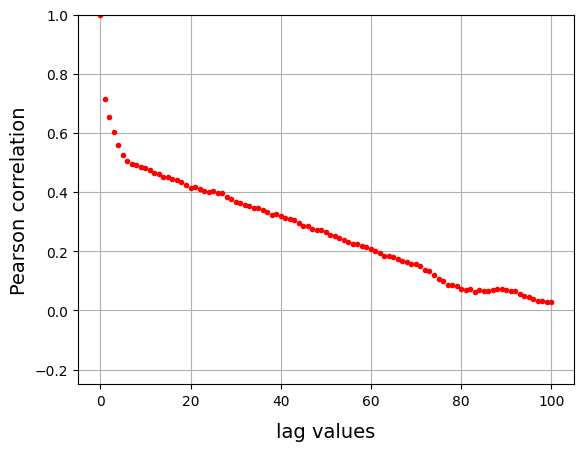

<Figure size 400x400 with 0 Axes>

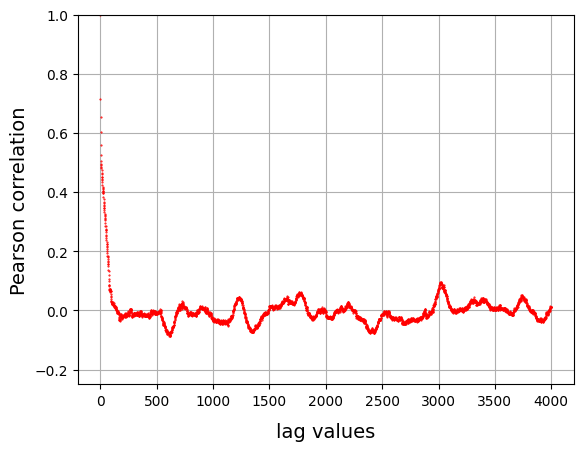

In [125]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

val = [[100,3],[4000,0.5]] #Values for lag and markersize

#KV Service
for i in [0,1]:
    fig = plt.figure(figsize=(4, 4))
    plot_acf(Y_KV, lags = val[i][0], markersize = val[i][1], alpha=None, color= 'r', use_vlines=False, title=None)
    plt.ylim(-0.25,1)
    plt.xlabel('lag values', fontsize=14, labelpad=10)
    plt.ylabel('Pearson correlation', fontsize=14)
    plt.grid(True)
    plt.savefig(bbox_inches='tight')
    plt.show()

<Figure size 400x400 with 0 Axes>

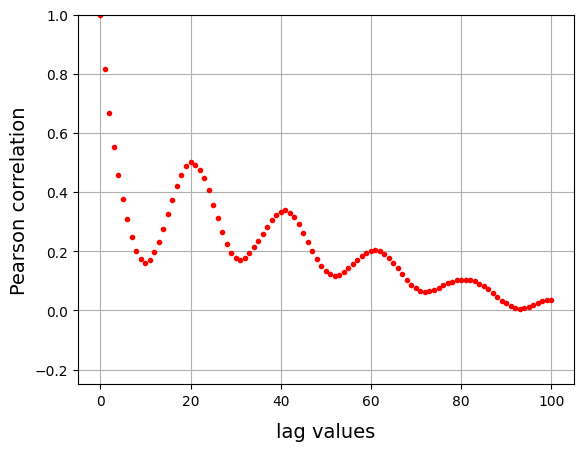

<Figure size 400x400 with 0 Axes>

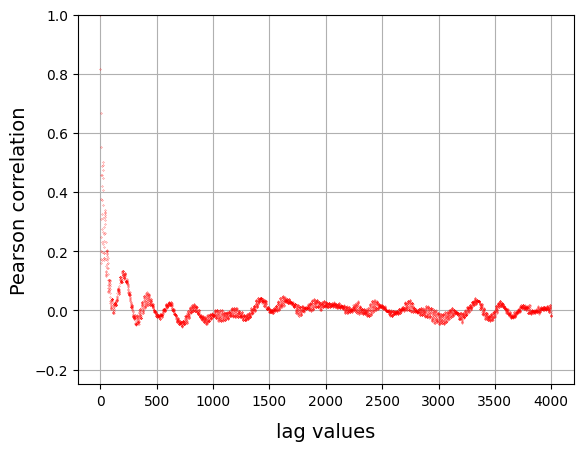

In [136]:
val = [[100,3],[4000,0.2]] #Values for lag and markersize

#VoD Service
for i in [0,1]:
    fig = plt.figure(figsize=(4, 4))
    plot_acf(Y_VoD, lags = val[i][0], markersize = val[i][1], color= 'r', alpha=None, use_vlines=False, title=None)
    plt.ylim(-0.25,1)
    plt.xlabel('lag values', fontsize=14, labelpad=10)
    plt.ylabel('Pearson correlation', fontsize=14)
    plt.grid(True)
    plt.show()

<Figure size 400x400 with 0 Axes>

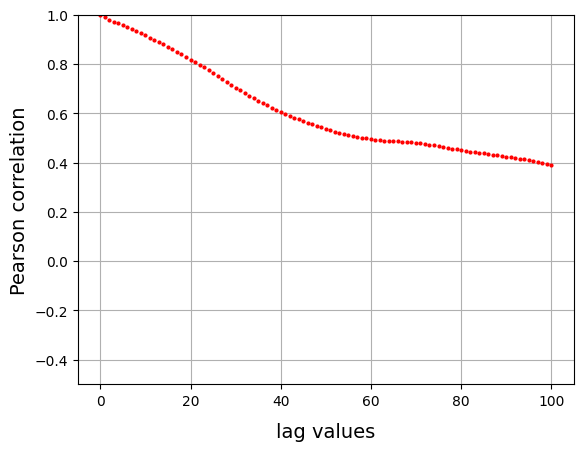

<Figure size 400x400 with 0 Axes>

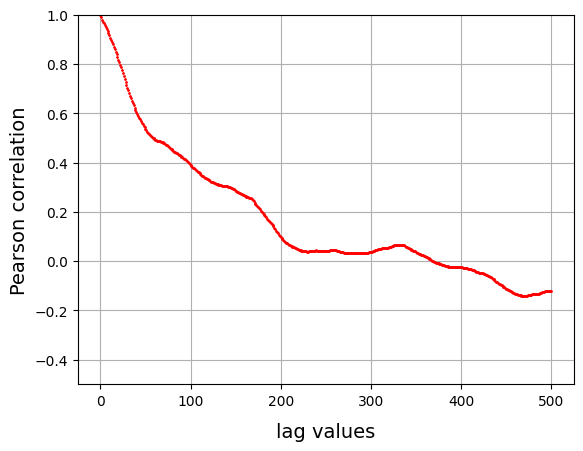

In [124]:
#FedCSIS

val = [[100,2],[500,1]] #Values for lag and markersize

for i in [0,1]:
    fig = plt.figure(figsize=(4, 4))
    plot_acf(Y_CSIS, lags = val[i][0], markersize = val[i][1], color= 'r', alpha=None, use_vlines=False, title=None)
    plt.ylim(-0.5,1)
    plt.xlabel('lag values', fontsize=14, labelpad=10)
    plt.ylabel('Pearson correlation', fontsize=14)
    plt.grid(True)
    plt.show()

### Quiz 3
Quiz 3: For the time series X = [1, 2, 3, 2, 4, 4, 5, 6, 5, 5, 7, 6], fit an autoregression model with parameter p = 2. Using this model, forecast the next two values of X (horizon h = 2). Similarly, use MA and ARIMA methods and fit a model to the same time series with parameters q = 1 and d = 1. Forecast the values for h = 2.

In [108]:
X = [1, 2, 3, 2, 4, 4, 5, 6, 5, 5, 7, 6]

In [ ]:
from statsmodels.tsa.ar_model import AutoReg